In [1]:
# permite a utilização de caminhos relativos ao projeto, mesmo no diretório de notebooks

from knapsax.utils import setrootdir

setrootdir("knapsax")

'Directory knapsax successfully loaded as current working directory.'

In [2]:
from typing import List, Tuple, Dict, Callable
import random
import time
from tqdm import tqdm
import tracemalloc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from knapsax.optimization import Problem, Maximize, Solution, Knapsack
from knapsax.aco import ACO

In [3]:
knapsack = Knapsack(instance_file="data/knapsack-instance.txt")
knapsack

Knapsack(file=data/knapsack-instance.txt, n_items=100, capacity=1550)

In [5]:
aco = ACO(
    knapsack,
    n_ants=50, n_best=10, n_iterations=100,
    decay=0.95, alpha=1, beta=2
)
best_solution, best_value, best_weight = aco.run()

print("Items:", [knapsack.items[i] for i in best_solution])
print("Best Value:", best_value)
print("Weight:", best_weight)

Items: [Item(value=41, weight=26), Item(value=32, weight=21), Item(value=24, weight=17), Item(value=30, weight=15), Item(value=52, weight=37), Item(value=52, weight=36), Item(value=49, weight=34), Item(value=57, weight=42), Item(value=61, weight=45), Item(value=59, weight=44), Item(value=54, weight=39), Item(value=18, weight=12), Item(value=69, weight=53), Item(value=22, weight=14), Item(value=33, weight=23), Item(value=23, weight=15), Item(value=16, weight=10), Item(value=19, weight=13), Item(value=27, weight=19), Item(value=34, weight=22), Item(value=40, weight=27), Item(value=45, weight=29), Item(value=42, weight=31), Item(value=29, weight=21), Item(value=20, weight=16), Item(value=46, weight=30), Item(value=50, weight=35), Item(value=39, weight=25), Item(value=28, weight=20), Item(value=44, weight=28), Item(value=53, weight=38), Item(value=56, weight=41), Item(value=47, weight=33), Item(value=88, weight=66), Item(value=43, weight=31), Item(value=50, weight=35), Item(value=58, weigh

# Análise do comportamento médio

In [6]:
class Stats:
    def __init__(self, n_runs: int, algorithm_instance: object):
        self.n_runs = n_runs
        self.algorithm_instance = algorithm_instance
        self.data = {
            "iteration": [],
            "best_solution": [],
            "best_value": [],
            "best_weight": [],
            "history_value": [],
            "history_weight": [],
            "execution_time": [],
            "memory_peak": [],
            "memory_peak_mb": [],
        }

    def run(self):

        for i in tqdm(range(self.n_runs), desc="Running ACO", unit="run"):
            start_time = time.time()
            tracemalloc.start()
            best_solution, best_value, best_weight = self.algorithm_instance.run()
            current, peak = tracemalloc.get_traced_memory()
            tracemalloc.stop()
            end_time = time.time()

            self.data["iteration"].append(i)
            self.data["best_solution"].append(best_solution)
            self.data["best_value"].append(best_value)
            self.data["best_weight"].append(best_weight)
            self.data["history_value"].append(self.algorithm_instance.history_value)
            self.data["history_weight"].append(self.algorithm_instance.history_weight)
            self.data["execution_time"].append(end_time - start_time)
            self.data["memory_peak"].append(peak)
            self.data["memory_peak_mb"].append(peak / 10**6)

    def frame(self):
        return pd.DataFrame(self.data)
    
    def plot_convergence(self, title: str, savefig: str = None):
        df = self.frame()

        value_by_run = np.array(df["history_value"].tolist())
        value_by_iteration = value_by_run.T

        means_by_iteration = np.mean(value_by_iteration, axis=1)
        std_by_iteration = np.std(value_by_iteration, axis=1)
        max_value = np.nanmax(value_by_iteration)

        fig, ax = plt.subplots(figsize=(10, 6))

        sns.lineplot(
            x=np.arange(len(means_by_iteration)),
            y=means_by_iteration,
            ax=ax,
            label="Média do custo",
            color="royalblue",
            linewidth=2.5
        )

        ax.fill_between(
            np.arange(len(means_by_iteration)),
            means_by_iteration - std_by_iteration,
            means_by_iteration + std_by_iteration,
            color="royalblue",
            alpha=0.2,
            label="Desvio padrão do custo"
        )

        ax.axhline(
            y=max_value,
            linestyle="--",
            color="forestgreen",
            linewidth=2,
            label=f"Valor máximo = {max_value}"
        )

        ax.set_title(title, fontsize=20)
        ax.set_xlabel("Iteração", fontsize=16)
        ax.set_ylabel("Custo", fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=12)
        ax.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
        ax.legend(fontsize=12, frameon=True)
        plt.tight_layout()

        if savefig:
            plt.savefig(savefig, dpi=600)
        
        return fig, ax

In [7]:
aco = ACO(
    knapsack,
    n_ants=50, n_best=10, n_iterations=100,
    decay=0.95, alpha=1, beta=2
)

In [8]:
aco_stats = Stats(
    n_runs=10,
    algorithm_instance=aco
)

aco_stats.run()

Running ACO: 100%|██████████| 10/10 [05:21<00:00, 32.13s/run]


In [9]:
aco_stats.frame()

,iteration,best_solution,best_value,best_weight,history_value,history_weight,execution_time,memory_peak,memory_peak_mb
0,0,"[3, 8, 24, 38, 62, 99, 85, 2, 83, 5, 18, 10, 2...",2192,1550,"[2063, 2116, 2116, 2150, 2153, 2153, 2153, 215...","[1546, 1545, 1545, 1547, 1548, 1548, 1548, 154...",33.309371,214733,0.214733
1,1,"[11, 14, 2, 26, 81, 56, 99, 64, 37, 29, 13, 49...",2192,1549,"[2063, 2116, 2116, 2150, 2153, 2153, 2153, 215...","[1546, 1545, 1545, 1547, 1548, 1548, 1548, 154...",31.516937,210656,0.210656
2,2,"[18, 51, 87, 85, 99, 13, 74, 44, 14, 55, 20, 7...",2193,1550,"[2063, 2116, 2116, 2150, 2153, 2153, 2153, 215...","[1546, 1545, 1545, 1547, 1548, 1548, 1548, 154...",31.364756,212558,0.212558
3,3,"[10, 3, 58, 70, 31, 12, 47, 13, 76, 44, 38, 78...",2193,1550,"[2063, 2116, 2116, 2150, 2153, 2153, 2153, 215...","[1546, 1545, 1545, 1547, 1548, 1548, 1548, 154...",32.501811,214046,0.214046
4,4,"[20, 47, 37, 22, 53, 64, 93, 66, 92, 29, 85, 7...",2195,1550,"[2063, 2116, 2116, 2150, 2153, 2153, 2153, 215...","[1546, 1545, 1545, 1547, 1548, 1548, 1548, 154...",32.346376,215755,0.215755
5,5,"[60, 16, 70, 71, 12, 33, 40, 93, 74, 83, 67, 6...",2194,1550,"[2063, 2116, 2116, 2150, 2153, 2153, 2153, 215...","[1546, 1545, 1545, 1547, 1548, 1548, 1548, 154...",32.002297,218498,0.218498
6,6,"[20, 3, 76, 29, 81, 8, 11, 74, 35, 55, 89, 38,...",2194,1550,"[2063, 2116, 2116, 2150, 2153, 2153, 2153, 215...","[1546, 1545, 1545, 1547, 1548, 1548, 1548, 154...",32.052103,220322,0.220322
7,7,"[14, 22, 74, 8, 71, 11, 93, 18, 42, 35, 60, 12...",2194,1550,"[2063, 2116, 2116, 2150, 2153, 2153, 2153, 215...","[1546, 1545, 1545, 1547, 1548, 1548, 1548, 154...",31.854596,221412,0.221412
8,8,"[64, 31, 13, 33, 53, 42, 2, 74, 76, 8, 60, 99,...",2195,1550,"[2063, 2116, 2116, 2150, 2153, 2153, 2153, 215...","[1546, 1545, 1545, 1547, 1548, 1548, 1548, 154...",32.347540,223383,0.223383
9,9,"[42, 16, 22, 18, 27, 3, 49, 20, 37, 51, 70, 83...",2194,1549,"[2063, 2116, 2116, 2150, 2153, 2153, 2153, 215...","[1546, 1545, 1545, 1547, 1548, 1548, 1548, 154...",32.045644,225389,0.225389


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Convergência do ACO para o problema da mochila'}, xlabel='Iteração', ylabel='Custo'>)

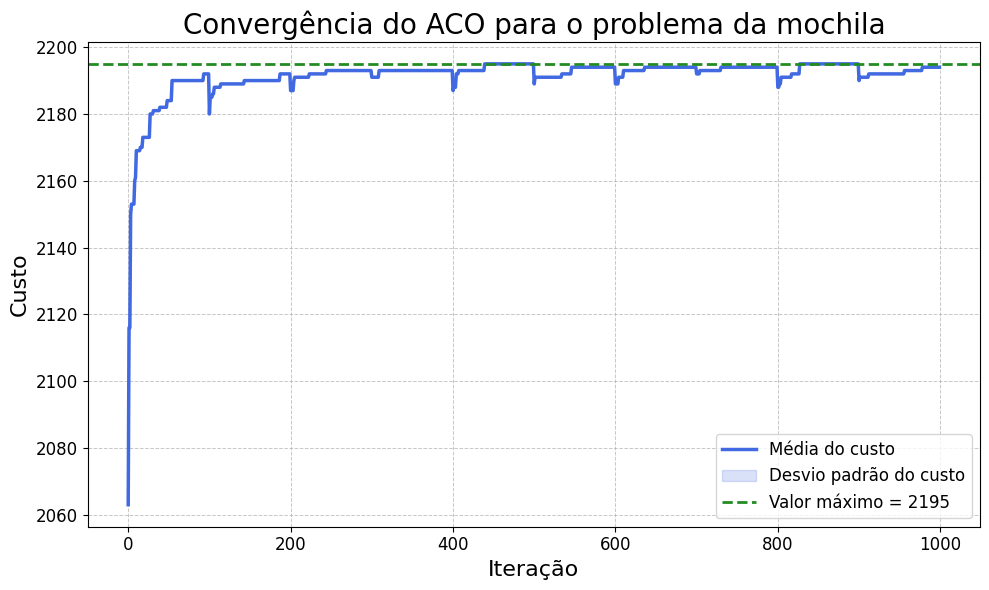

In [10]:
aco_stats.plot_convergence(
    title="Convergência do ACO para o problema da mochila",
    savefig="results/aco_convergence.png"
)